### Import required libraries

In [337]:
import pandas as pd # For loading the data and processing it
import numpy as np
import seaborn as sns           # data visualization
import matplotlib.pyplot as plt # for data visualization
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

### Load dataset (assume '?' are missing values)

In [338]:
# define specific data types for each attribute
data_types =   {'hours.per.week' : 'uint8',   
                'occupation'     : 'category',
                'fnlwgt'         : 'int32',   
                'sex'            : 'category',
                'education.num'  : 'uint8',   
                'relationship'   : 'category',
                'workclass'      : 'category',
                'marital.status' : 'category',  
                'race'           : 'category',
                'education'      : 'category',
                'capital.loss'   : 'int32',   
                'capital.gain'   : 'int32',  
                'age'            : 'uint8',   
                'native.country' : 'category',
                'income'         : 'category'}

#load the data

df = pd.read_csv("adult.csv", na_values='?', dtype = data_types)
df.head()

age workclass  fnlwgt     education  education.num marital.status         occupation  \
0  90   NaN       77053   HS-grad       9              Widowed        NaN                 
1  82   Private   132870  HS-grad       9              Widowed        Exec-managerial     
2  66   NaN       186061  Some-college  10             Widowed        NaN                 
3  54   Private   140359  7th-8th       4              Divorced       Machine-op-inspct   
4  41   Private   264663  Some-college  10             Separated      Prof-specialty      

    relationship   race     sex  capital.gain  capital.loss  hours.per.week native.country income  
0  Not-in-family  White  Female  0             4356          40              United-States  <=50K  
1  Not-in-family  White  Female  0             4356          18              United-States  <=50K  
2  Unmarried      Black  Female  0             4356          40              United-States  <=50K  
3  Unmarried      White  Female  0             3900          40              United-States  <=50K  
4  Own-child      White  Female  0             3900          40              United-States  <=50K

In [339]:
print("Number of rows: ", df.shape[0], "\nNumber of columns: ",df.shape[1])

Number of rows:  32561 
Number of columns:  15


### Data Dictionary for Adult Census Income

In [340]:
data_dictionary = pd.read_csv("data_dictionary.csv")
data_dictionary.style.set_properties(subset=['Description'], **{'text-align': 'left'})

### Look at some unique values for each column

In [341]:
def rstr(df): return df.apply(lambda x: x.unique().tolist()[:5])
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(rstr(df), columns=['Values'])

Values
age             [90, 82, 66, 54, 41]                                                    
workclass       [nan, Private, State-gov, Federal-gov, Self-emp-not-inc]                
fnlwgt          [77053, 132870, 186061, 140359, 264663]                                 
education       [HS-grad, Some-college, 7th-8th, 10th, Doctorate]                       
education.num   [9, 10, 4, 6, 16]                                                       
marital.status  [Widowed, Divorced, Separated, Never-married, Married-civ-spouse]       
occupation      [nan, Exec-managerial, Machine-op-inspct, Prof-specialty, Other-service]
relationship    [Not-in-family, Unmarried, Own-child, Other-relative, Husband]          
race            [White, Black, Asian-Pac-Islander, Other, Amer-Indian-Eskimo]           
sex             [Female, Male]                                                          
capital.gain    [0, 99999, 41310, 34095, 27828]                                         
capital.loss    [4356, 3900, 3770, 3683, 3004]                                          
hours.per.week  [40, 18, 45, 20, 60]                                                    
native.country  [United-States, nan, Mexico, Greece, Vietnam]                           
income          [<=50K, >50K]

### Display dataframe info

In [342]:
# display additional information about the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  uint8   
 1   workclass       30725 non-null  category
 2   fnlwgt          32561 non-null  int32   
 3   education       32561 non-null  category
 4   education.num   32561 non-null  uint8   
 5   marital.status  32561 non-null  category
 6   occupation      30718 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  capital.gain    32561 non-null  int32   
 11  capital.loss    32561 non-null  int32   
 12  hours.per.week  32561 non-null  uint8   
 13  native.country  31978 non-null  category
 14  income          32561 non-null  category
dtypes: category(9), int32(3), uint8(3)
memory usage: 767.1 KB


### Inspect columns with missing values

In [343]:
# Number of null values per column
df.isnull().sum()

age               0   
workclass         1836
fnlwgt            0   
education         0   
education.num     0   
marital.status    0   
occupation        1843
relationship      0   
race              0   
sex               0   
capital.gain      0   
capital.loss      0   
hours.per.week    0   
native.country    583 
income            0   
dtype: int64

In [344]:
plt.title("Workclass Distribution", fontsize=20)
df['workclass'].value_counts().plot(kind='bar');

In [345]:
plt.title("Native Country Distribution", fontsize=20)
df['native.country'].value_counts().plot(kind='bar');

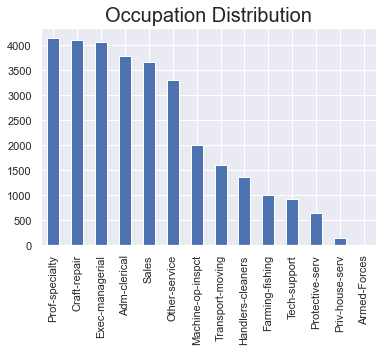

In [346]:
plt.title("Occupation Distribution", fontsize=20)
df['occupation'].value_counts().plot(kind='bar');

### Fill missing values with mode

In [347]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

### View distributions of categorical columns

In [348]:
cat_columns = list(df.select_dtypes(include=["category"]).columns)
fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0.6, wspace=0.2)

for i,c in enumerate(cat_columns):
    ax = fig.add_subplot(3, 3, i+1)
    plt.title(c+" Distribution")
    sns.countplot(x=df[c]);
    if df[c].nunique() > 2:
        plt.xticks(rotation = 90);
        
plt.show()

### View Mean and 5 Number Summary for numerical columns

In [349]:
df.describe().T.applymap(lambda x: "{:,}".format(round(x)))[['mean','min','25%','50%','75%','max']]

mean     min      25%      50%      75%        max
age             39       17      28       37       48       90       
fnlwgt          189,778  12,285  117,827  178,356  237,051  1,484,705
education.num   10       1       9        10       12       16       
capital.gain    1,078    0       0        0        0        99,999   
capital.loss    87       0       0        0        0        4,356    
hours.per.week  40       1       40       40       45       99

### View histograms of numeric columns

In [350]:
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.6, wspace=0.2)
i=1

for c in df.columns:
    if c not in cat_columns:
        ax = fig.add_subplot(3, 2, i)
        ax.ticklabel_format(useOffset=False, style='plain') # disable scientific notation
        i+=1
        df[c].hist()
        plt.title(f"Distribution of {c}", fontsize=20)
        plt.ylabel('Count');
        plt.xlabel(c);
plt.show()

### Exploring our response variable income

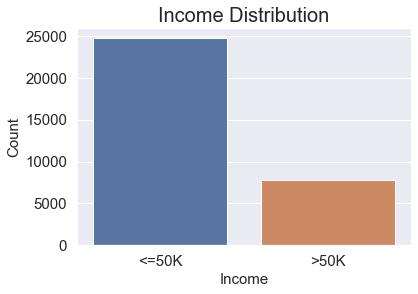

In [351]:
plt.title("Income Distribution", fontsize=20)
sns.countplot(x=df['income']);
plt.ylabel('Count',fontsize=15);
plt.xlabel('Income',fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

In [352]:
# Plotting income against some features to see relationships

# create age intervals
bins = pd.interval_range(min(df.age), max(df.age), freq=10)
df['age_intervals'] = pd.cut(df["age"], bins)
cat_columns2 = list(df.select_dtypes(include=["category"]).columns)

filtered_columns = list(filter(lambda c: c not in ['income', 'native.country','occupation','age','relationship'], cat_columns2))

fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.6, wspace=0.2)

for i, c in enumerate(filtered_columns):
    ax = fig.add_subplot(3, 2, i+1)
    plt.title(f"Income by {c} Distribution", fontsize=20)
    sns.countplot(x=df[c], hue = df['income']);
    plt.ylabel('Count');
    plt.xlabel(c);
    if df[c].nunique() > 2:
        plt.xticks(rotation = 90);
        
plt.show()
df.drop('age_intervals',axis=1, inplace=True)


### Correlation of variables

In [353]:
### Map income to binary values

df['income']=pd.to_numeric(df['income'].map({'<=50K': 0, '>50K': 1}))

In [354]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(round(df.corr(),2), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

### Label encoding categorical columns

In [355]:
for c in cat_columns:
        le = preprocessing.LabelEncoder()
        df.loc[:, c] = le.fit_transform(df.loc[:, c]).copy()

In [356]:
# After label encoding
df.head()

age  workclass  fnlwgt  education  education.num  marital.status  occupation  relationship  \
0  90   3          77053   11         9              6               9           1              
1  82   3          132870  11         9              6               3           1              
2  66   3          186061  15         10             6               9           4              
3  54   3          140359  5          4              0               6           4              
4  41   3          264663  15         10             5               9           3              

   race  sex  capital.gain  capital.loss  hours.per.week  native.country  income  
0  4     0    0             4356          40              38              0       
1  4     0    0             4356          18              38              0       
2  2     0    0             4356          40              38              0       
3  4     0    0             3900          40              38              0       
4  4     0    0             3900          40              38              0

### Since education and education.num both represent education level, we will drop education

In [357]:
df.drop(['education'], axis=1, inplace=True)

### Set predictor and response variables (X and y)

In [358]:
X = df.drop(['income'], axis=1)

y = df['income']

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

### Logistic Regression

In [360]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion_matrix(y_test, y_pred)
acc_logreg = logreg.score(X_test, y_test)

print('Logistic Regression Accuracy: {0:.2%}'.format(acc_logreg))

Logistic Regression Accuracy: 80.12%


### Feature Importance for Logistic Regression

In [361]:
# feature importance
importance = logreg.coef_[0]
plt.bar([x for x in range(len(importance))], importance)
plt.show()

feature_imp = pd.DataFrame(columns=['Feature','Score'])
for i,v in enumerate(importance):
    f = pd.DataFrame(data={'Feature':[X.columns[i]], 'Score':[round(v,4)]})
    feature_imp=feature_imp.append(f)
feature_imp['Absolute Score']=abs(feature_imp['Score'])
feature_imp=feature_imp.sort_values(by='Absolute Score', ascending=False).reset_index(drop=True)
feature_imp

Feature   Score  Absolute Score
0   native.country -0.0110  0.0110        
1   hours.per.week -0.0066  0.0066        
2   age            -0.0062  0.0062        
3   occupation     -0.0015  0.0015        
4   education.num  -0.0014  0.0014        
5   marital.status -0.0014  0.0014        
6   relationship   -0.0013  0.0013        
7   workclass      -0.0010  0.0010        
8   race           -0.0010  0.0010        
9   capital.loss    0.0009  0.0009        
10  capital.gain    0.0003  0.0003        
11  fnlwgt         -0.0000  0.0000        
12  sex             0.0000  0.0000

In [362]:
# Select Bottom 3 Features to Drop
drop_features = feature_imp[-3:]['Feature']

### Confusion Matrix for Logistic Regression

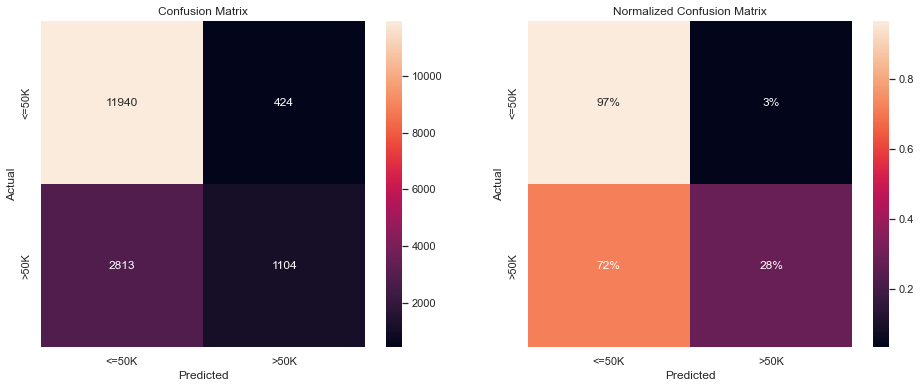

In [363]:
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

sns.heatmap(cm, ax=ax1, annot=True, fmt='.0f')
ax1.set(title="Confusion Matrix",xlabel="Predicted", ylabel="Actual", xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])

sns.heatmap(cmn, ax=ax2, annot=True, fmt='.0%', xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
ax2.set(title="Normalized Confusion Matrix",xlabel="Predicted", ylabel="Actual", xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])

plt.show(block=False)

### K-Nearest Neighbors

### Hyperparameter Tuning for KNN (different values of k)

In [364]:
# KNN
maxf1 = 0
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train) 
    Y_pred = knn.predict(X_test)
    acc_knn = knn.score(X_test, y_test)
    f1_knn = f1_score(y_test, Y_pred, average="macro")
    if f1_knn > maxf1:
        maxf1 = f1_knn
        bestk = k
    print('K-Nearest Neighbors ( k =',k,') F-1 Score: {0:.2%}'.format(f1_knn))
print("\n\nMax F-1 Score: {0:.2%}".format(maxf1),
     "\nK =",bestk)

K-Nearest Neighbors ( k = 1 ) F-1 Score: 62.59%
K-Nearest Neighbors ( k = 2 ) F-1 Score: 61.79%
K-Nearest Neighbors ( k = 3 ) F-1 Score: 62.58%
K-Nearest Neighbors ( k = 4 ) F-1 Score: 61.29%
K-Nearest Neighbors ( k = 5 ) F-1 Score: 62.10%
K-Nearest Neighbors ( k = 6 ) F-1 Score: 61.09%
K-Nearest Neighbors ( k = 7 ) F-1 Score: 62.24%
K-Nearest Neighbors ( k = 8 ) F-1 Score: 60.90%
K-Nearest Neighbors ( k = 9 ) F-1 Score: 61.73%
K-Nearest Neighbors ( k = 10 ) F-1 Score: 60.91%


Max F-1 Score: 62.59% 
K = 1


In [365]:
knn = KNeighborsClassifier(n_neighbors = bestk)
knn.fit(X_train, y_train) 
Y_pred = knn.predict(X_test)
acc_knn = knn.score(X_test, y_test)
f1_knn = f1_score(y_test, Y_pred, average="macro")

### Decision Trees

In [366]:
# Decision Trees
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = decision_tree.score(X_test, y_test)
print('Decision Trees Accuracy: {0:.2%}'.format(acc_decision_tree))

Decision Trees Accuracy: 81.03%


### Cross Validation

In [367]:
def cross_validation(model_name,model, X, y,n_splits):
    kf=KFold(n_splits=n_splits)
    scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
    results = cross_validate(estimator=model, X=X, y=y, cv=kf, scoring=scoring, return_train_score=True)
    r = pd.DataFrame(data={'Model':[modelname], 
         'Accuracy':[results['test_accuracy'].mean()],
         'Precision':[results['test_precision'].mean()],
         'Recall':[results['test_recall'].mean()],
         'F1':[results['test_f1'].mean()]})
    return r

In [368]:
models = {'Logistic Regression': logreg, 'KNN':knn, 'Decision Tree':decision_tree}

### 5-Fold Cross Validation results including all original features

In [369]:
r = pd.DataFrame()

for modelname, model in models.items():
    res = cross_validation(model_name=modelname,model=model,X=X,y=y,n_splits=5)
    r = r.append(res)

In [370]:
print("\n\n5-Fold Cross Validation results including all original features:")
r.style.format({
    'Accuracy': '{:,.1%}'.format,
    'Precision': '{:,.1%}'.format,
    'Recall': '{:,.1%}'.format,
    'F1': '{:,.1%}'.format
})



5-Fold Cross Validation results including all original features:


### Remove features with low importance then run cross validation again

In [371]:
# Remove features with low importance then run cross validation again
X2 = df.drop(['income']+list(drop_features), axis=1)

r2 = pd.DataFrame()

for modelname, model in models.items():
    res = cross_validation(model_name=modelname,model=model,X=X2,y=y,n_splits=5)
    r2 = r2.append(res)

In [372]:
print("\n\n5-Fold Cross Validation results after removing 3 features:",list(drop_features))
r2.style.format({
    'Accuracy': '{:,.1%}'.format,
    'Precision': '{:,.1%}'.format,
    'Recall': '{:,.1%}'.format,
    'F1': '{:,.1%}'.format
})



5-Fold Cross Validation results after removing 3 features: ['capital.gain', 'fnlwgt', 'sex']


### Compare Logistic Regression, KNN, Decision Tree

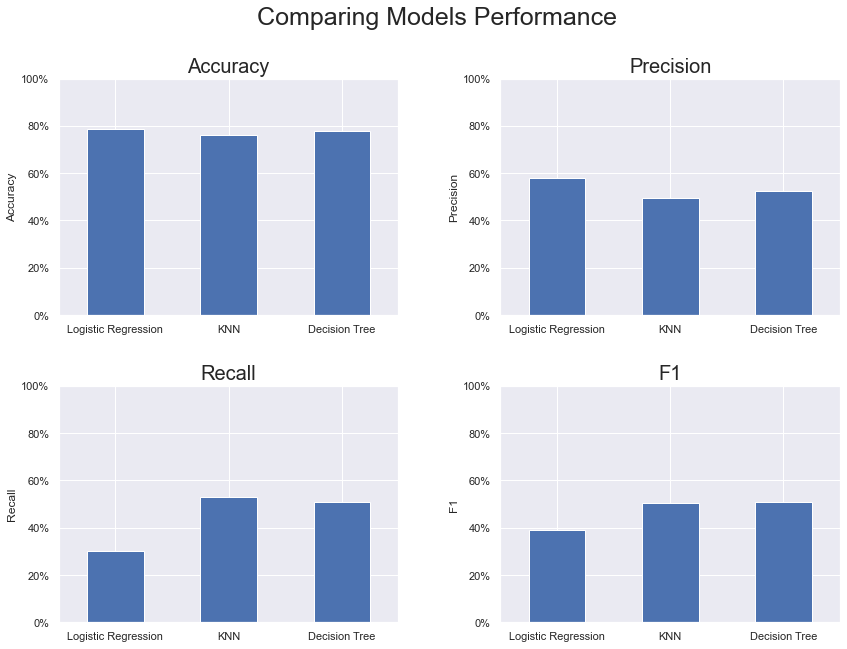

In [373]:
final_results = r2.set_index('Model')

fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i,c in enumerate(final_results.columns):
    ax = fig.add_subplot(2, 2, i+1)
    final_results[c].plot(y=c,kind='bar', use_index=True);
    plt.title(c, fontsize=20)
    plt.ylabel(c);
    plt.xlabel('');
    plt.xticks(rotation = 0)
    plt.ylim(bottom=0,top=1) 
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
fig.suptitle('Comparing Models Performance', fontsize=25)
plt.show()

In [405]:
# Model with best F-1 Score
best_model = final_results[final_results['F1']==max(final_results['F1'])].index.values.tolist()[0]
best_model_f1 = "{:,.1%}".format(final_results.loc[best_model]['F1'])

### Since our class is unbalanced, accuracy may be misleading
### We are most interested in F-1 score
### F1-Score is a measure that combines both Precision and Recall, and accounts for the imbalance in the response variable

In [407]:
print(f"The model with the best performance is {best_model} with F1-Score = {best_model_f1}")

The model with the best performance is Decision Tree with F1-Score = 51.0%
